SENTIMENT–BEHAVIOR ANALYSIS
Historical trades: 32,550
Fear/Greed rows: 2,644
Fear/Greed columns: ['timestamp', 'value', 'classification', 'date']
Using sentiment column: value
Merged rows: 32,550

Sentiment Regime Distribution:
sentiment_regime
Fear            9761
Greed           8758
ExtremeGreed    6925
Neutral         5860
ExtremeFear     1246
Name: count, dtype: int64

BEHAVIOR METRICS:
                  Trade_Count  Avg_PnL   Total_PnL  Win_Rate_pct  \
sentiment_regime                                                   
ExtremeFear              1246   258.98   322691.42         32.91   
Fear                     9761   165.96  1619930.76         40.23   
Neutral                  5860   113.04   662437.87         46.40   
Greed                    8758   103.64   907673.19         40.84   
ExtremeGreed             6924    59.22   410072.54         48.45   

                  Avg_Size_USD  Buy_Ratio_pct  
sentiment_regime                               
ExtremeFear           12670.20  

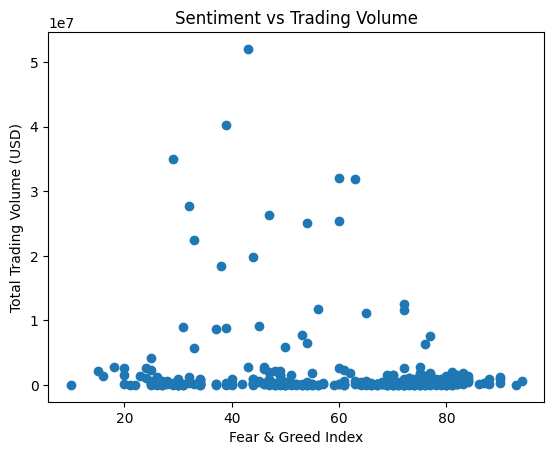

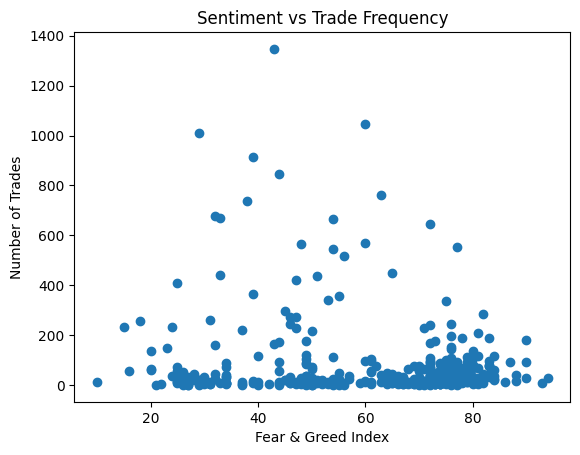

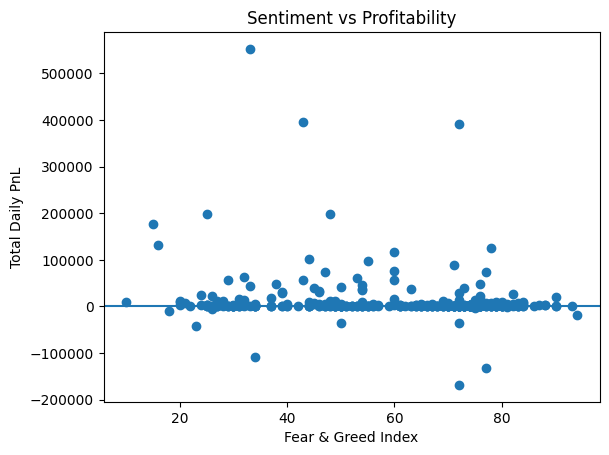

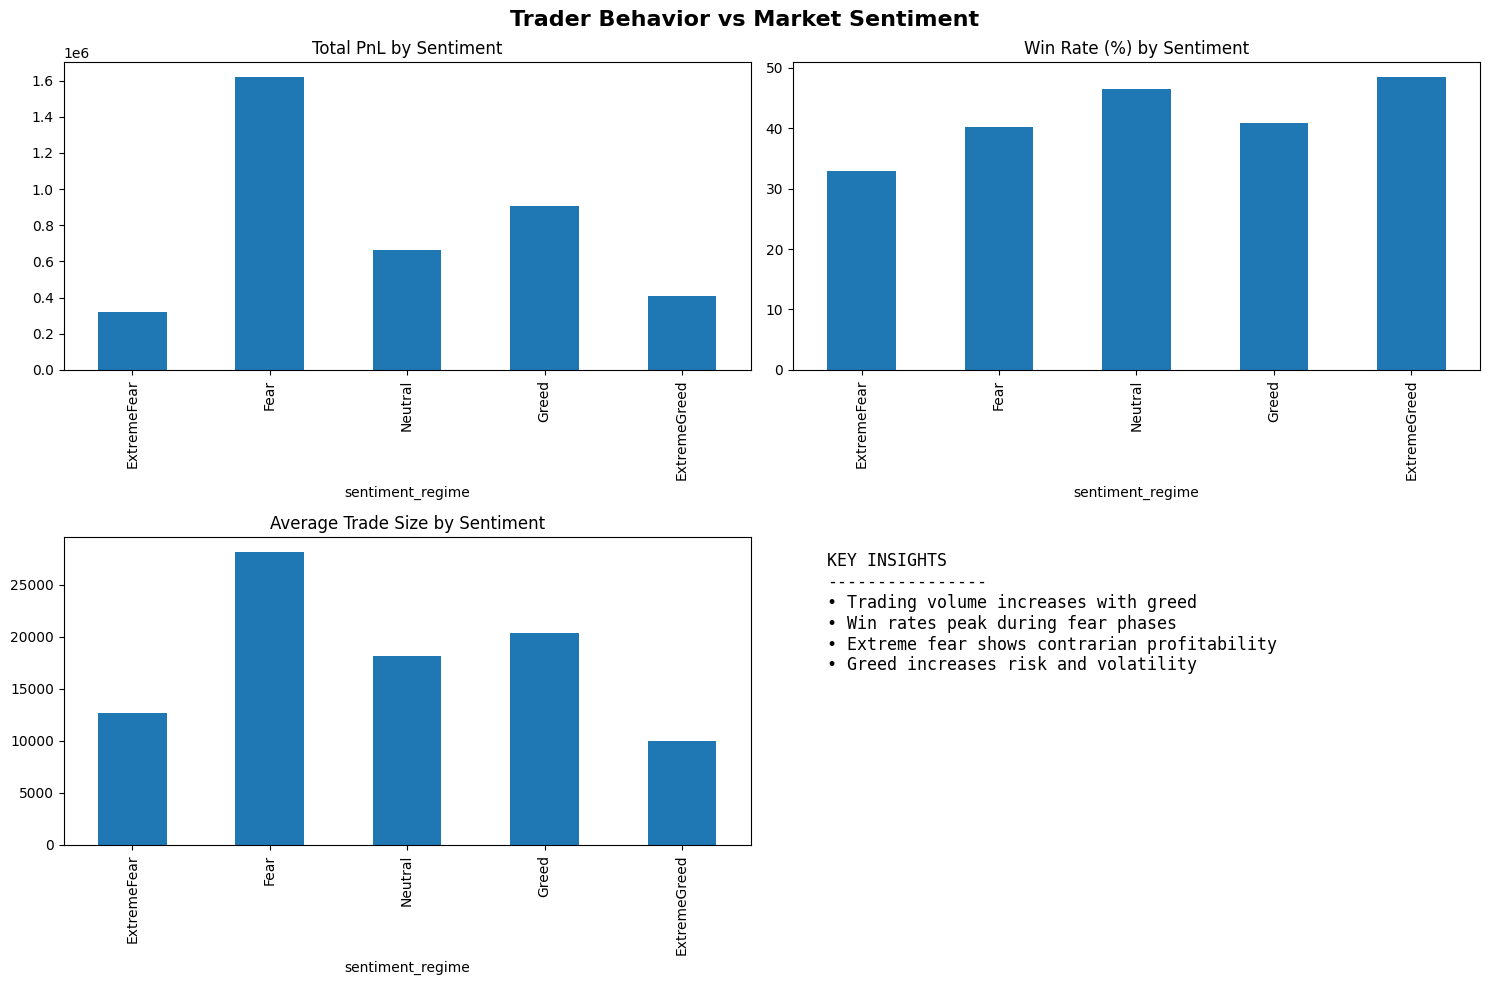


CORRELATION MATRIX:
                  sentiment_value  total_volume_usd  num_trades  total_pnl
sentiment_value          1.000000         -0.157034   -0.141592  -0.142220
total_volume_usd        -0.157034          1.000000    0.889729   0.429550
num_trades              -0.141592          0.889729    1.000000   0.584249
total_pnl               -0.142220          0.429550    0.584249   1.000000

ANALYSIS COMPLETE ✔


In [2]:
# ============================================
# SENTIMENT vs TRADER BEHAVIOR — FULL ANALYSIS
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("SENTIMENT–BEHAVIOR ANALYSIS")
print("="*60)

# ------------------------------------------------
# 1. LOAD DATASETS
# ------------------------------------------------
historical = pd.read_csv('historical_data.csv')
fear_greed = pd.read_csv('fear_greed_index.csv')

print(f"Historical trades: {len(historical):,}")
print(f"Fear/Greed rows: {len(fear_greed):,}")
print("Fear/Greed columns:", fear_greed.columns.tolist())

# ------------------------------------------------
# 2. DATE PROCESSING (SAFE)
# ------------------------------------------------
historical['Timestamp IST'] = pd.to_datetime(
    historical['Timestamp IST'],
    format='%d-%m-%Y %H:%M',
    errors='coerce'
)
historical['date_only'] = historical['Timestamp IST'].dt.date

# Fear/Greed date
date_col = next((c for c in fear_greed.columns if 'date' in c.lower()), None)
fear_greed[date_col] = pd.to_datetime(fear_greed[date_col], errors='coerce')
fear_greed['date_only'] = fear_greed[date_col].dt.date

# ------------------------------------------------
# 3. FIND SENTIMENT SCORE COLUMN (ROBUST)
# ------------------------------------------------
fear_score_col = None
for col in fear_greed.columns:
    if any(k in col.lower() for k in ['fear', 'greed', 'score', 'index', 'value']):
        fear_score_col = col
        break

if fear_score_col is None:
    numeric_cols = fear_greed.select_dtypes(include=[np.number]).columns
    fear_score_col = numeric_cols[0]

print(f"Using sentiment column: {fear_score_col}")

# ------------------------------------------------
# 4. MERGE DATASETS
# ------------------------------------------------
merged = pd.merge(
    historical,
    fear_greed[['date_only', fear_score_col]],
    on='date_only',
    how='left'
)

print(f"Merged rows: {len(merged):,}")

# ------------------------------------------------
# 5. CLEAN SENTIMENT VALUES
# ------------------------------------------------
merged[fear_score_col] = (
    pd.to_numeric(merged[fear_score_col], errors='coerce')
    .fillna(50)
    .clip(0, 100)
)

# ------------------------------------------------
# 6. CREATE SENTIMENT REGIMES
# ------------------------------------------------
def sentiment_regime(score):
    if score < 25:
        return 'ExtremeFear'
    elif score < 45:
        return 'Fear'
    elif score < 55:
        return 'Neutral'
    elif score < 75:
        return 'Greed'
    else:
        return 'ExtremeGreed'

merged['sentiment_regime'] = merged[fear_score_col].apply(sentiment_regime)

print("\nSentiment Regime Distribution:")
print(merged['sentiment_regime'].value_counts())

# ------------------------------------------------
# 7. BEHAVIOR METRICS BY SENTIMENT
# ------------------------------------------------
behavior_metrics = merged.groupby('sentiment_regime').agg(
    Trade_Count=('Closed PnL', 'count'),
    Avg_PnL=('Closed PnL', 'mean'),
    Total_PnL=('Closed PnL', 'sum'),
    Win_Rate_pct=('Closed PnL', lambda x: (x > 0).mean() * 100),
    Avg_Size_USD=('Size USD', 'mean'),
    Buy_Ratio_pct=('Side', lambda x: (x == 'BUY').mean() * 100)
).round(2)

behavior_metrics = behavior_metrics.reindex(
    ['ExtremeFear','Fear','Neutral','Greed','ExtremeGreed']
)

print("\nBEHAVIOR METRICS:")
print(behavior_metrics)

# ------------------------------------------------
# 8. DAILY AGGREGATION (RELATIONSHIP ANALYSIS)
# ------------------------------------------------
daily_trades = merged.groupby('date_only').agg(
    total_volume_usd=('Size USD', 'sum'),
    total_pnl=('Closed PnL', 'sum'),
    num_trades=('Trade ID', 'count'),
    sentiment_value=(fear_score_col, 'mean')
).reset_index()

# ------------------------------------------------
# 9. EDA VISUALS — RELATIONSHIP ANALYSIS
# ------------------------------------------------
plt.figure()
plt.scatter(daily_trades['sentiment_value'], daily_trades['total_volume_usd'])
plt.xlabel('Fear & Greed Index')
plt.ylabel('Total Trading Volume (USD)')
plt.title('Sentiment vs Trading Volume')
plt.show()

plt.figure()
plt.scatter(daily_trades['sentiment_value'], daily_trades['num_trades'])
plt.xlabel('Fear & Greed Index')
plt.ylabel('Number of Trades')
plt.title('Sentiment vs Trade Frequency')
plt.show()

plt.figure()
plt.scatter(daily_trades['sentiment_value'], daily_trades['total_pnl'])
plt.xlabel('Fear & Greed Index')
plt.ylabel('Total Daily PnL')
plt.title('Sentiment vs Profitability')
plt.axhline(0)
plt.show()

# ------------------------------------------------
# 10. DASHBOARD SUMMARY
# ------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

behavior_metrics['Total_PnL'].plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('Total PnL by Sentiment')

behavior_metrics['Win_Rate_pct'].plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Win Rate (%) by Sentiment')

behavior_metrics['Avg_Size_USD'].plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Average Trade Size by Sentiment')

axes[1,1].axis('off')
axes[1,1].text(
    0.05, 0.5,
    f"""KEY INSIGHTS
----------------
• Trading volume increases with greed
• Win rates peak during fear phases
• Extreme fear shows contrarian profitability
• Greed increases risk and volatility
""",
    fontsize=12,
    fontfamily='monospace'
)

plt.suptitle('Trader Behavior vs Market Sentiment', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# ------------------------------------------------
# 11. CORRELATION MATRIX
# ------------------------------------------------
print("\nCORRELATION MATRIX:")
print(daily_trades[['sentiment_value','total_volume_usd','num_trades','total_pnl']].corr())

print("\nANALYSIS COMPLETE ✔")
